In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio as rp
import warnings
warnings.filterwarnings("ignore")

In [2]:
dows_df = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
dows_tickers = dows_df.Symbol.tolist()
dows_tickers.sort()
assert len(dows_tickers) == 30
SP500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
SP500_tickers = SP500_df.Symbol.tolist()
SP500_tickers.remove('BF.B')  # delisted
SP500_tickers.remove('BRK.B')  # delisted
SP500_tickers.sort()

In [3]:
def download_data_and_calc_returns(tickers, period='5y', interval='1d', prepost=False):
    data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
    data = data.loc[:,('Adj Close', slice(None))]  # get adjusted close only
    data.columns = tickers
    data = data[tickers].pct_change().dropna()
    return data

dows_returns = download_data_and_calc_returns(dows_tickers)

[*********************100%***********************]  30 of 30 completed


In [4]:
dows_returns.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-21,0.036830,0.004029,0.009479,-0.009198,0.007894,0.021038,0.012767,0.009383,-0.012092,-0.016466,...,0.010600,0.022975,0.015227,0.007570,0.023148,0.006068,0.013333,0.010751,0.012900,0.004258
2019-03-22,-0.020708,-0.027047,-0.021105,-0.028253,-0.032001,-0.032644,-0.022247,-0.022009,-0.003957,-0.007758,...,-0.007957,-0.026368,-0.066129,-0.008098,0.003944,-0.019562,-0.017522,0.025218,-0.018711,-0.007874
2019-03-25,-0.012091,-0.000589,-0.003837,0.022890,0.012407,-0.003839,-0.000190,-0.001625,-0.004065,0.011317,...,0.000729,0.005211,0.001703,0.002951,0.000371,-0.000931,-0.000262,0.005355,-0.011537,-0.001119
2019-03-26,-0.010332,0.009004,0.004219,-0.000216,0.003501,-0.009199,0.009482,0.010090,0.021802,-0.006104,...,0.006921,0.002125,0.012754,0.010396,0.000222,-0.014056,0.014834,0.009154,0.003728,0.001528
2019-03-27,0.008994,-0.010357,-0.004749,0.010341,-0.004854,-0.026851,-0.001691,-0.010795,0.001271,0.025588,...,-0.007598,-0.009668,-0.003478,-0.001165,0.010150,-0.006903,-0.006955,0.004123,0.005007,-0.011290


In [5]:
port = rp.Portfolio(returns=dows_returns, lowerret=(pow(1.5, 0.2) - 1)/252)  # daily return NOT annual
port.assets_stats()
risk_measure = 'SLPM'
objective = 'MinRisk'
risk_free_rate = 0.04/252
allocations = port.optimization(rm=risk_measure, obj=objective, rf=risk_free_rate)

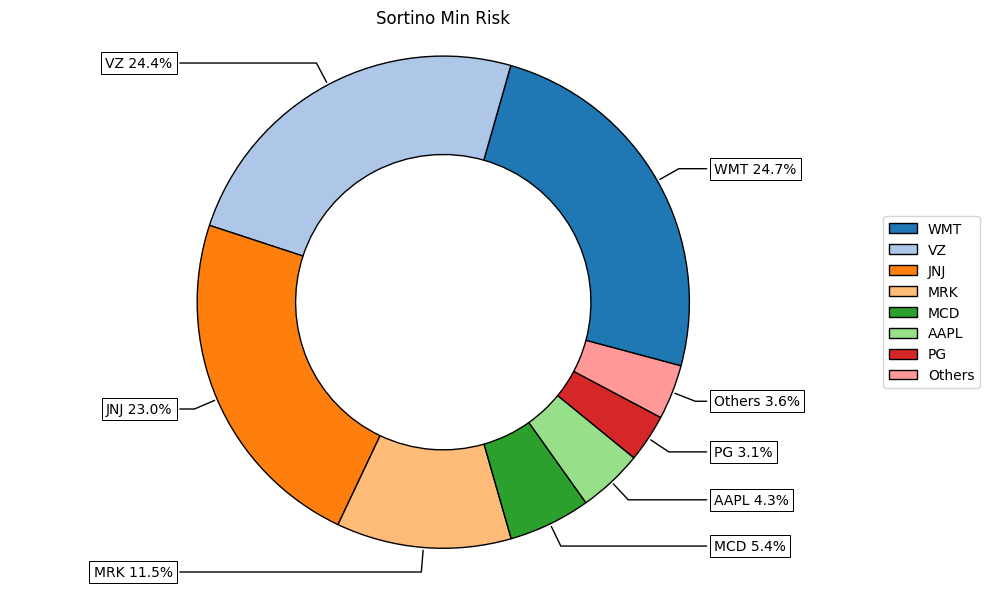

In [6]:
ax = rp.plot_pie(w=allocations, title='Sortino Min Risk', others=0.05, nrow=len(port.assetslist), cmap = "tab20", height=6, width=10, ax=None)

In [7]:
frontier = port.efficient_frontier(rm=risk_measure, points=100, rf=risk_free_rate)
display(frontier.T.head())

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,0.042661,0.029489,7.628018e-12,2.469335e-12,0.005361,1.144499e-11,7.581249e-12,4.373480e-11,1.212143e-11,5.594369e-12,...,0.114876,3.528821e-11,1.693855e-11,0.031340,3.064025e-11,8.699813e-11,1.317989e-11,0.243695,6.372189e-12,0.247442
1,0.064887,0.024211,2.878080e-11,8.789580e-12,0.007436,3.569737e-11,2.573477e-11,1.719779e-10,3.996048e-11,2.080918e-11,...,0.118930,1.210413e-10,5.456452e-11,0.038314,1.186898e-10,4.021421e-09,4.496450e-11,0.211482,2.213343e-11,0.249752
2,0.079892,0.020480,8.921870e-12,2.633772e-12,0.008608,9.970234e-12,7.536219e-12,4.939284e-11,1.141936e-11,6.434249e-12,...,0.121474,3.494182e-11,1.538365e-11,0.042774,3.689072e-11,8.426757e-03,1.309615e-11,0.186202,6.567918e-12,0.252307
3,0.092552,0.017531,4.076949e-11,1.154838e-11,0.009378,4.204177e-11,3.293547e-11,2.089825e-10,4.912594e-11,2.937796e-11,...,0.123894,1.513295e-10,6.544349e-11,0.046548,1.684611e-10,1.687994e-02,5.699422e-11,0.163285,2.897142e-11,0.254938
4,0.103969,0.015116,1.162866e-11,3.218911e-12,0.009622,1.124811e-11,9.076086e-12,5.563779e-11,1.335041e-11,8.397872e-12,...,0.125823,4.120340e-11,1.764625e-11,0.049688,4.805627e-11,2.448375e-02,1.561328e-11,0.141987,8.045040e-12,0.257489


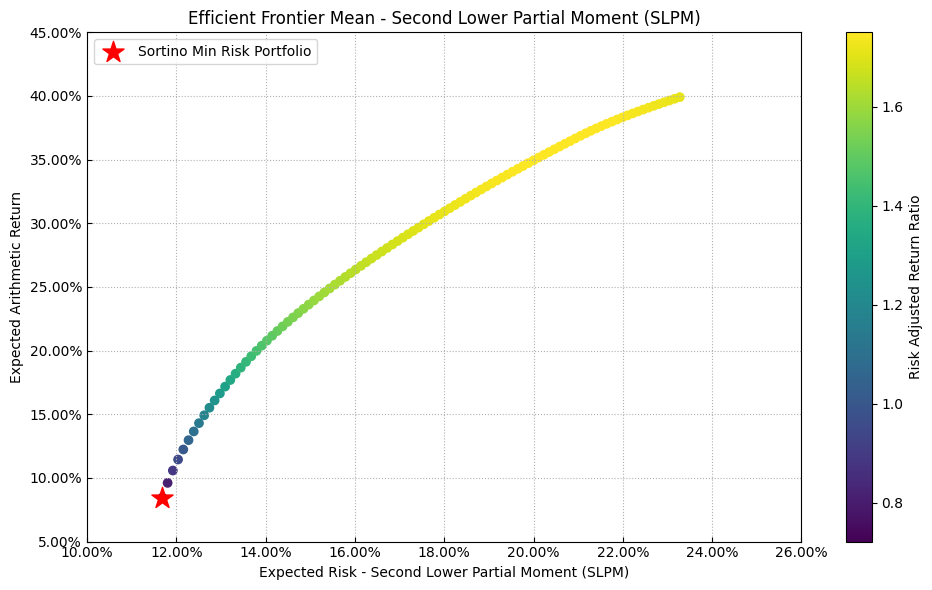

In [8]:
# Plotting the efficient frontier
label = 'Sortino Min Risk Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=risk_measure, alpha=0.05, cmap='viridis', rf=risk_free_rate, w=allocations, label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

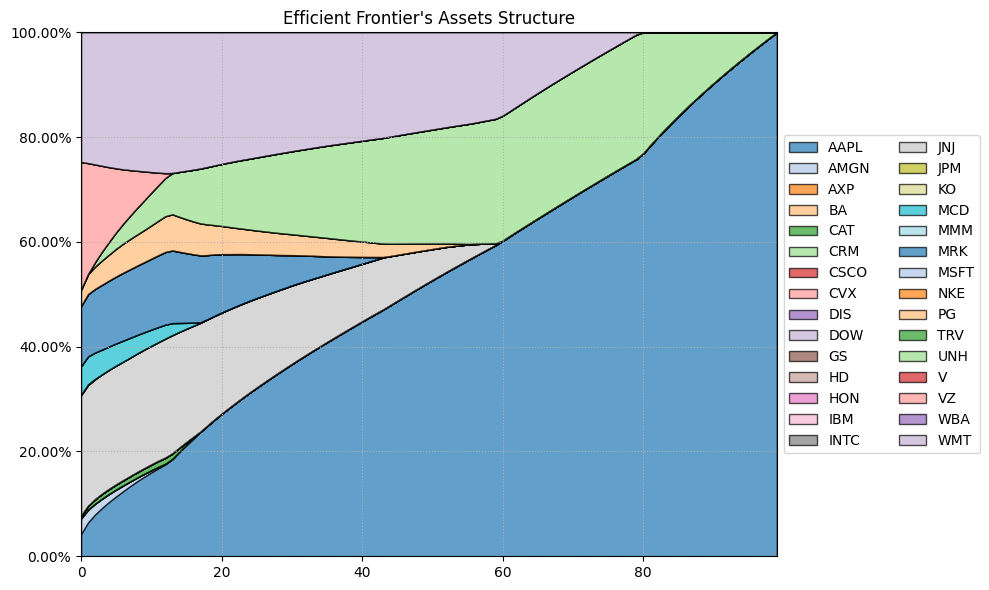

In [9]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot: title={'center': 'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot: title={'center': 'Portfolio Composition'}>,
       <AxesSubplot: title={'center': 'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot: title={'center': 'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

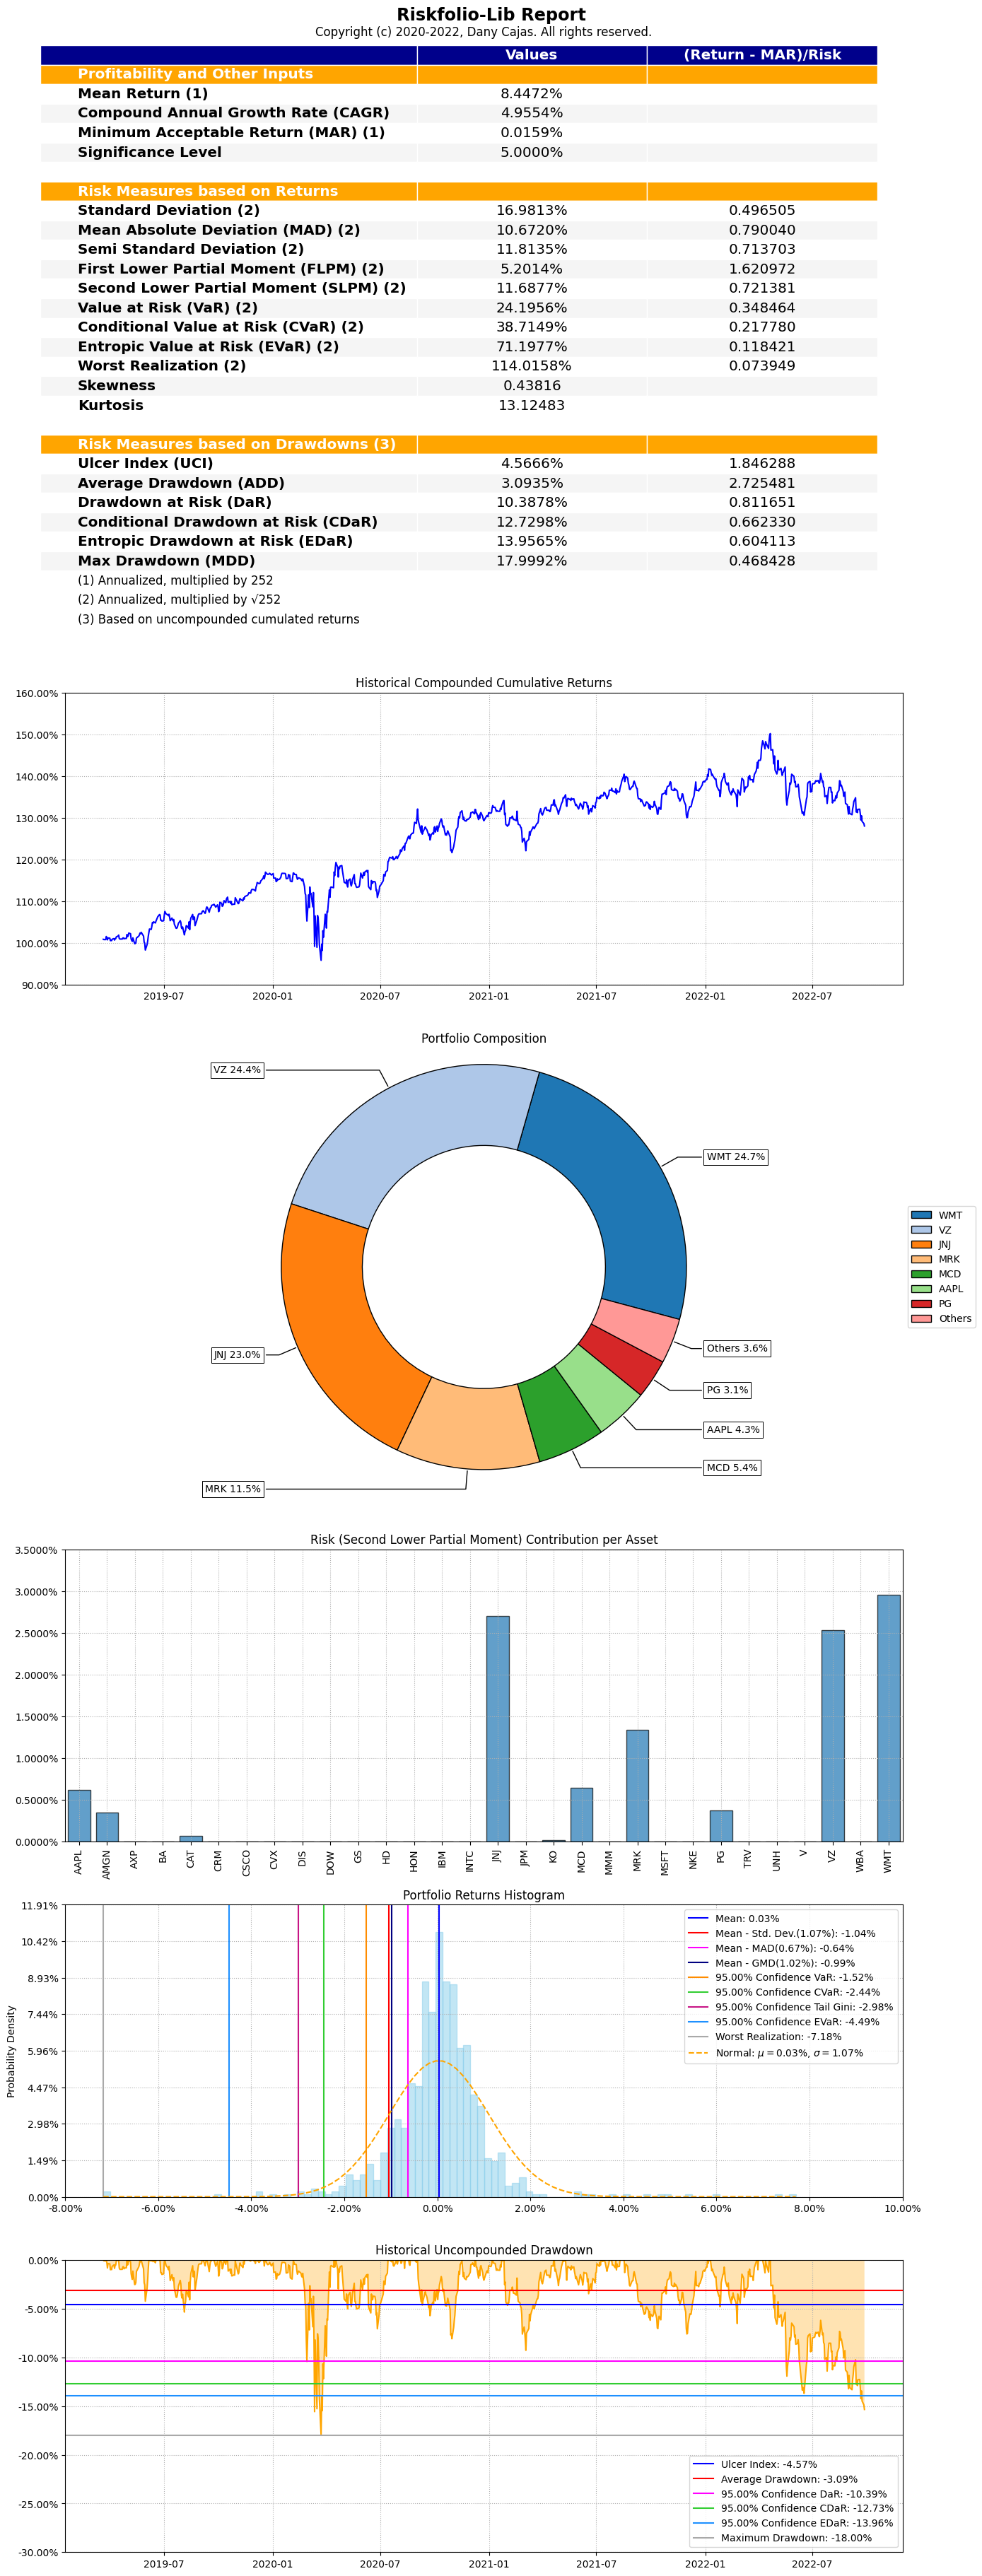

In [10]:
rp.Reports.excel_report(returns, allocations, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='dows_5y_report')
rp.Reports.jupyter_report(returns, allocations, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.05, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)

In [11]:

sp500_returns = download_data_and_calc_returns(SP500_tickers)
sp500_returns.head()

[*********************100%***********************]  501 of 501 completed


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-20,-0.006765,-0.031773,-0.021379,-0.010347,-0.016123,0.003701,0.002417,-0.010631,-0.003055,-0.011092,...,-0.022008,0.000881,0.002188,0.005470,-0.018339,-0.007068,-0.001866,-0.022783,-0.029318,0.006880
2022-01-21,-0.014124,-0.027446,-0.013867,-0.012765,-0.007893,-0.010235,0.006012,0.008981,-0.020602,-0.021415,...,-0.016647,0.000587,-0.015013,-0.007128,0.005351,0.005015,-0.004064,-0.014439,-0.038611,-0.008071
2022-01-24,0.004436,0.006749,0.029449,-0.004864,0.001364,0.000228,0.024198,-0.015974,0.010041,0.039507,...,-0.009924,-0.011580,0.008591,0.017948,0.004669,0.016903,0.009058,-0.007325,0.016518,-0.001298
2022-01-25,-0.025702,0.003047,-0.011297,-0.011385,0.007037,-0.003725,-0.048407,-0.004442,-0.011947,-0.032598,...,0.019575,0.006674,0.029400,-0.021529,-0.034576,-0.033956,-0.021836,-0.033757,0.059105,-0.024092
2022-01-26,-0.007877,-0.013366,-0.021983,-0.000563,0.008566,-0.003891,0.001011,-0.025959,-0.015107,-0.003799,...,-0.003817,-0.003830,-0.010143,-0.003983,-0.012805,-0.015649,-0.003803,0.003587,0.010830,-0.027708


You must convert self.cov to a positive definite matrix


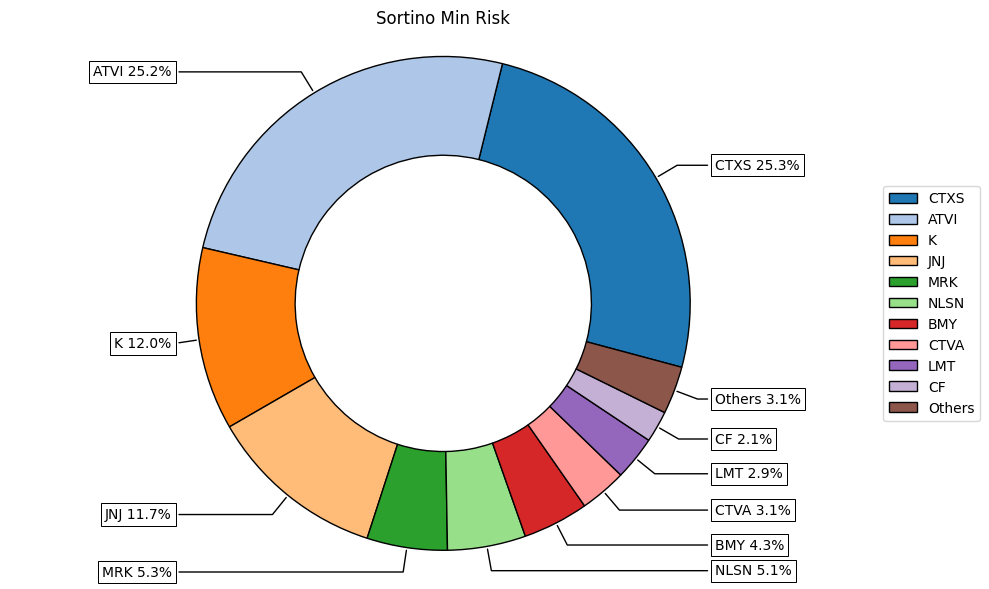

In [12]:
port = rp.Portfolio(returns=sp500_returns, lowerret=(pow(1.5, 0.2)-1)/252)
port.assets_stats()
risk_measure = 'SLPM'
objective = 'MinRisk'
allocations = port.optimization(rm=risk_measure, obj=objective, rf=risk_free_rate)
ax = rp.plot_pie(w=allocations, title='Sortino Min Risk', others=0.05, nrow=len(port.assetslist), cmap="tab20", height=6, width=10, ax=None)

In [13]:
frontier = port.efficient_frontier(rm=risk_measure, points=100, rf=risk_free_rate)
display(frontier.T.head())

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,3.250597e-12,1.758357e-12,2.320325e-12,2.740605e-12,3.172013e-11,7.692583e-12,1.954884e-12,3.405969e-12,2.535440e-12,1.950766e-12,...,3.237773e-12,2.453906e-11,1.642504e-10,2.807847e-12,2.820784e-12,7.161230e-12,3.810333e-12,1.815585e-12,4.201343e-12,3.635851e-12
1,1.313025e-12,7.349873e-13,9.319905e-13,1.154182e-12,1.400405e-11,2.997039e-12,8.131385e-13,1.314209e-12,1.001306e-12,7.719135e-13,...,1.190246e-12,8.364188e-12,3.226778e-11,1.061219e-12,1.188389e-12,2.459221e-12,1.546614e-12,7.502485e-13,1.728835e-12,1.338457e-12
2,2.888240e-12,1.564184e-12,1.984907e-12,2.616600e-12,3.650462e-11,6.378303e-12,1.726460e-12,2.829180e-12,2.160523e-12,1.576406e-12,...,2.440481e-12,1.823016e-11,4.823805e-11,2.203430e-12,2.711229e-12,5.051170e-12,3.425933e-12,1.543332e-12,3.891088e-12,2.777017e-12
3,5.852669e-12,3.233758e-12,4.018136e-12,5.446440e-12,8.098885e-11,1.259547e-11,3.501307e-12,5.703486e-12,4.388236e-12,3.179365e-12,...,4.839480e-12,3.688924e-11,7.986249e-11,4.416981e-12,5.610369e-12,9.892006e-12,7.021653e-12,3.094521e-12,7.933027e-12,5.503993e-12
4,2.973271e-12,1.668223e-12,2.041066e-12,2.810122e-12,4.254653e-11,6.045650e-12,1.800623e-12,2.874529e-12,2.224762e-12,1.592041e-12,...,2.396117e-12,1.753923e-11,2.743842e-11,2.182786e-12,2.902322e-12,4.836637e-12,3.610116e-12,1.539261e-12,3.909256e-12,2.727752e-12


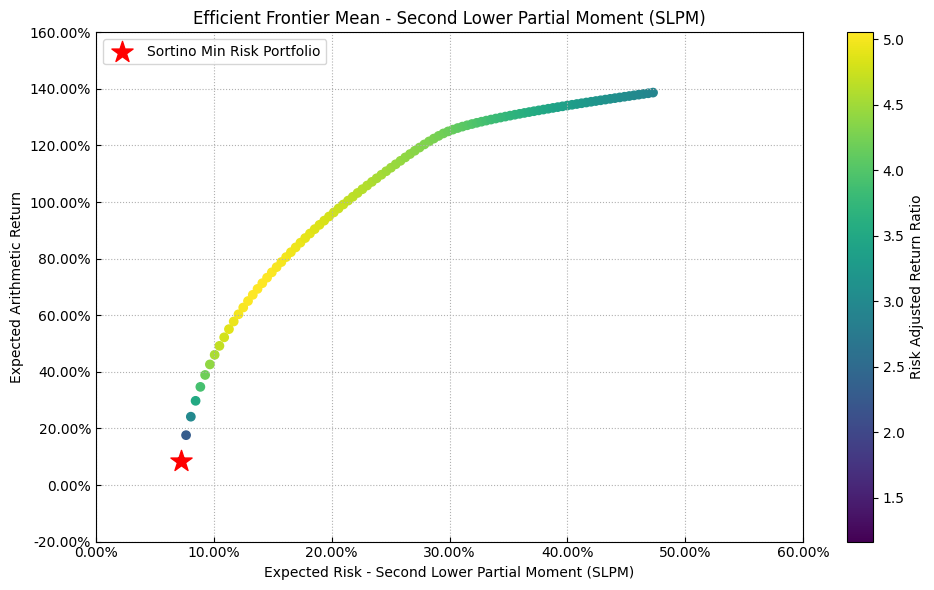

In [14]:
# Plotting the efficient frontier
label = 'Sortino Min Risk Portfolio'  # Title of point
mu = port.mu  # Expected returns
cov = port.cov  # Covariance matrix
returns = port.returns  # Returns of the assets
ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=risk_measure, rf=risk_free_rate, alpha=0.05, cmap='viridis', w=allocations, label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

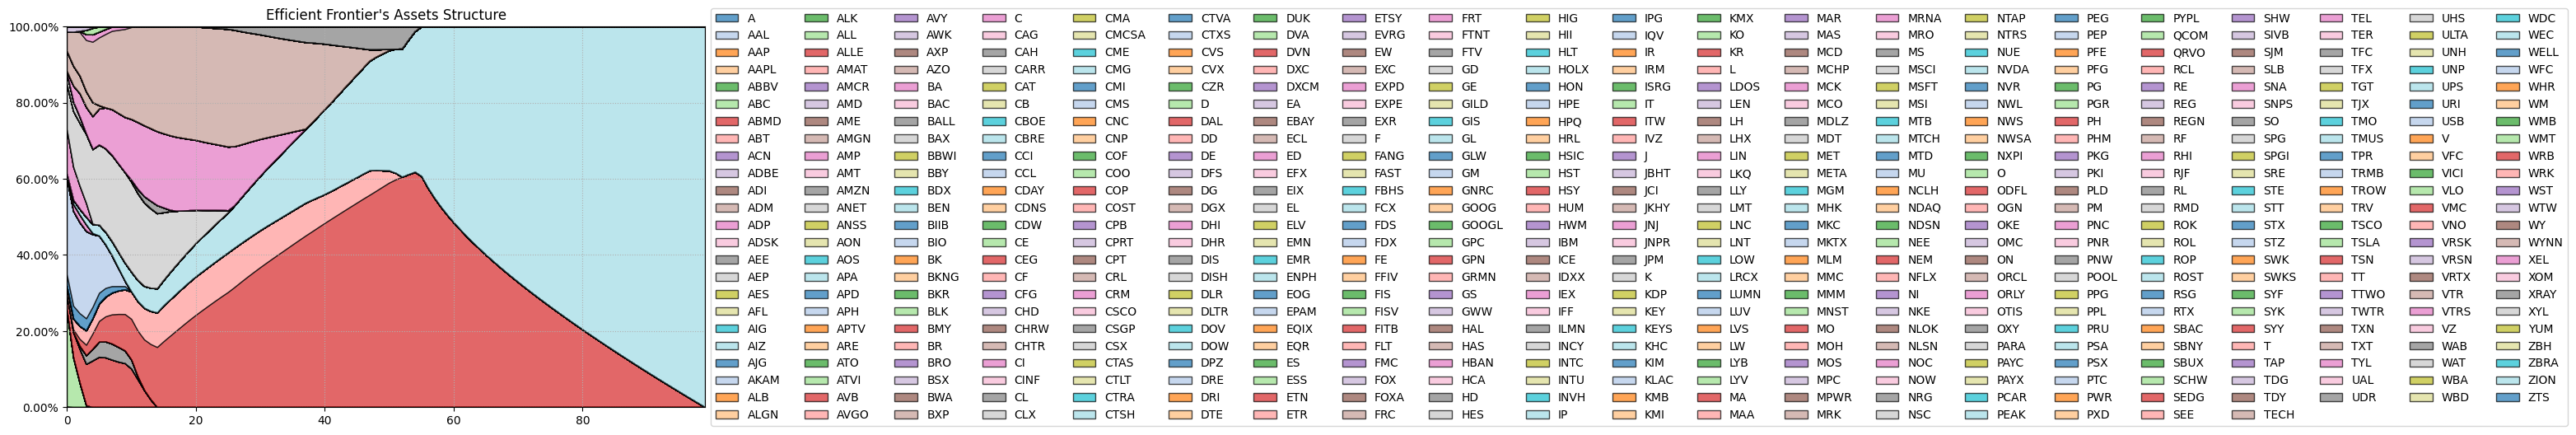

In [15]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot: title={'center': 'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot: title={'center': 'Portfolio Composition'}>,
       <AxesSubplot: title={'center': 'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot: title={'center': 'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

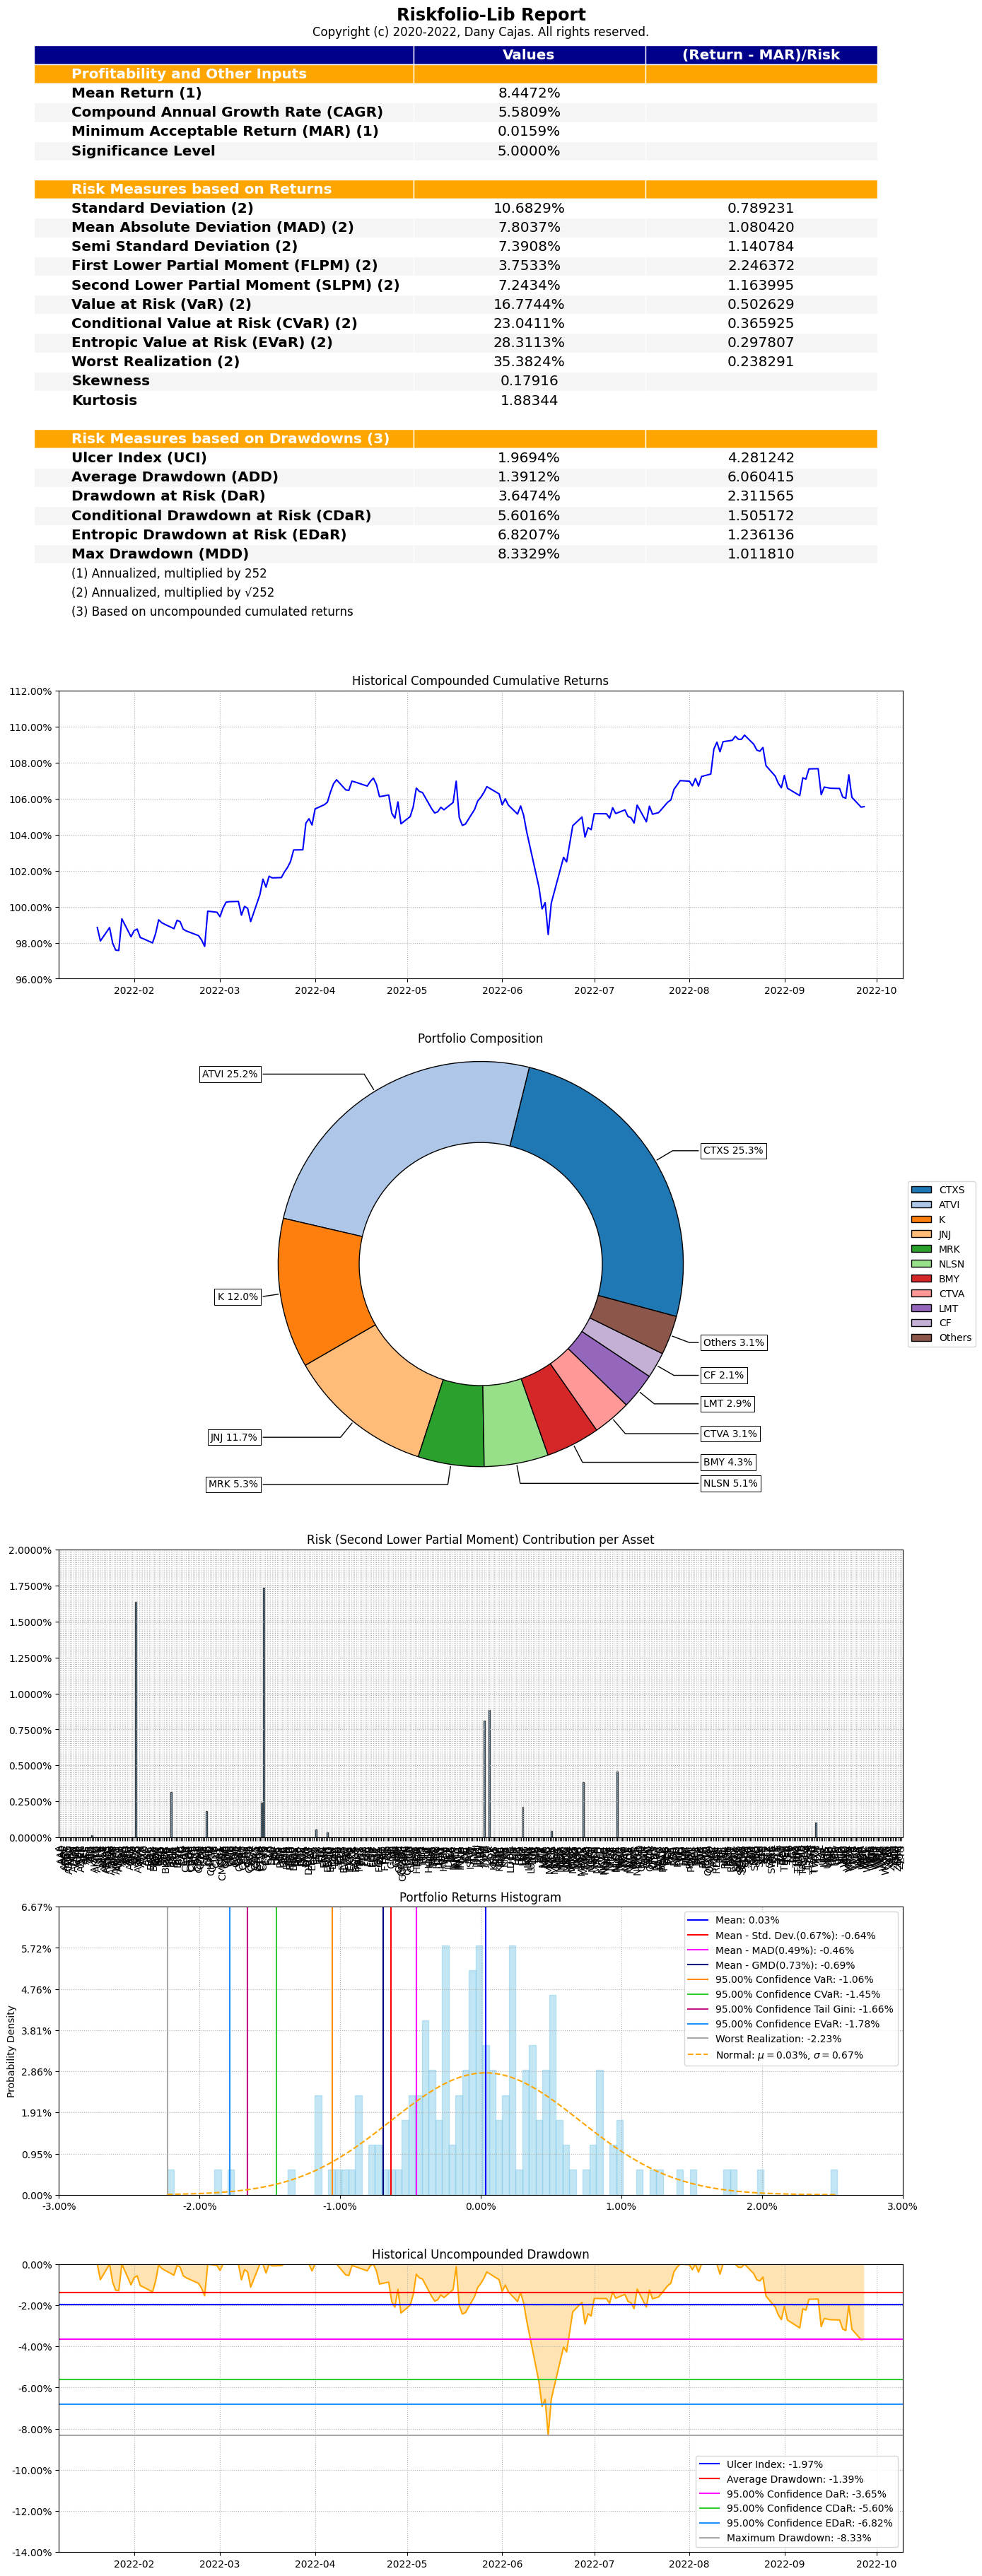

In [16]:
rp.Reports.excel_report(returns, allocations, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='sp500_5y_report')
rp.Reports.jupyter_report(returns, allocations, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.05, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)